<a href="https://colab.research.google.com/github/hsswkwk/turbo-chainsaw/blob/feature-add-image-classification/notebooks/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類（Image Classification）
入力した画像情報を「形」や「模様」、「色」など特徴量に分解し、入力情報から対象物を判定できるように対応付けを行う

#### 畳み込み層
特徴を抽出する層

#### プーリング層
画像サイズを小さくする層

<br>

## 画像分類のアーキテクチャ

#### CNN（Convolutional Neural Network）
畳み込みニューラルネットワーク（CNNまたはConvNet）は、畳み込みを使用しているニューラルネットワークの総称

#### ResNet
残差ニューラルネットワーク（ResNet）は、ウェイト層が層入力を参照して残差関数を学習する深層学習モデル

#### VGG16
ImageNetと呼ばれる大規模画像データセットで学習された16層(畳み込み13層、フル結合3層)からなる畳み込みニューラルネットワーク(CNN)

#### Efficient Net
複合スケーリング手法を用いて、ネットワークの幅、深さ、解像度を同時に最適化し、より少ないパラメータ数で高い精度を持つCNN


In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CIFAR-10データセットの読み込み
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
# CIFAR-10のクラスラベル
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# データの前処理（画素値を0-1の範囲に正規化）
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# データ拡張
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


@tf.keras.utils.register_keras_serializable()
class ResizeImage(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, image):
    image = tf.image.resize(image, (224, 224))
    return image

  def get_config(self):
    config = super().get_config()
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class ImageClassificationModelBase:
  def __init__(self, x_train, y_train, x_test, y_test, filepath):
    self.filename = filepath.split('/')[-1]
    self.name = self.filename.split('.')[0]
    if os.path.exists(filepath):
      self.model = tf.keras.models.load_model(filepath)
    else:
      self._build()
      # optimizer: 最適化アルゴリズム, loss: 損失関数, metrics: 評価指標
      self._compile()
      history = self._fit(x_train, y_train, x_test, y_test)
      self.model.save(self.filename)

  def evaluate(self, x_test,  y_test):
    test_loss, test_acc = self.model.evaluate(x_test,  y_test, verbose=2)
    print(f'\n{self.name}: Test accuracy: {test_acc}')

  def predict(self, x):
    return self.model.predict(np.expand_dims(x, axis=0))

  def _build(self):
    pass

  def _compile(self):
    self.model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

  def _fit(self, x_train, y_train, x_test, y_test):
    history = self.model.fit(
      datagen.flow(x_train, y_train, batch_size=32),
      batch_size=32,
      epochs=10,
      validation_data=(x_test, y_test))
    return history



class CnnModel(ImageClassificationModelBase):
  def _build(self):
    self.model = models.Sequential()
    self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    self.model.add(layers.MaxPooling2D((2, 2)))
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.MaxPooling2D((2, 2)))
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(64, activation='relu'))
    self.model.add(layers.Dense(10, activation='softmax'))

class ResNetModel(ImageClassificationModelBase):
  def _build(self):
    # ResNet50モデルの読み込み（ImageNetで事前学習済み）
    # ImageNet:
    # 物体認識ソフトウェアの研究において、ソフトウェアの最適化や性能の評価等に
    # 用いるために設計された、大規模な画像データセット
    resnet_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))
    resnet_model.trainable = True
    inputs = layers.Input(shape=(32, 32, 3))

    # ResNet50の出力層をCIFAR-10用に変更
    # 事前学習済みのResNet50モデルに、CIFAR-10のクラス数に対応する全結合層を追加
    x = ResizeImage()(inputs) # 入力画像の大きさをモデルに合わせる
    x = resnet_model(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    self.model = tf.keras.Model(inputs=inputs, outputs=outputs)


class Vgg16Model(ImageClassificationModelBase):
  def _build(self):
    vgg16_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
    vgg16_model.trainable = True
    inputs = layers.Input(shape=(32, 32, 3))

    x = ResizeImage()(inputs) # 入力画像の大きさをモデルに合わせる
    x = vgg16_model(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

  def _compile(self):
    self.model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.09),
        loss='categorical_crossentropy',
        metrics=['accuracy'])


class EfficientNetModel(ImageClassificationModelBase):
  def _build(self):
    efficientnet_model = applications.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224,224,3))
    efficientnet_model.trainable = True
    inputs = layers.Input(shape=(32, 32, 3))

    x = ResizeImage()(inputs) # 入力画像の大きさをモデルに合わせる
    x = efficientnet_model(x)
    x = layers.GlobalAveragePooling2D()(x) # GlobalAveragePooling2Dを追加
    x = layers.Dropout(0.5)(x) # 学習済みモデルの出力付近のレイヤー(トップレイヤー)は不要なので取り除く
    outputs = layers.Dense(10, activation="softmax")(x)
    self.model = tf.keras.Model(inputs=inputs, outputs=outputs)


  def _compile(self):
    self.model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.025),
        loss='categorical_crossentropy',
        metrics=['accuracy'])


# CNN
cnn_model = CnnModel(x_train, y_train, x_test, y_test, '/content/cnn.keras')
cnn_model.evaluate(x_test, y_test)

# ResNet
resnet_model = ResNetModel(x_train, y_train, x_test, y_test, '/content/resnet.keras')
resnet_model.evaluate(x_test, y_test)

# VGG16
vgg16_model = Vgg16Model(x_train, y_train, x_test, y_test, '/content/vgg16.keras')
vgg16_model.evaluate(x_test, y_test)

Efficient Net
effnet_model = EfficientNetModel(x_train, y_train, x_test, y_test, '/content/efficientnet.keras')
effnet_model.evaluate(x_test, y_test)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
313/313 - 3s - 11ms/step - accuracy: 0.6333 - loss: 1.0415

cnn: Test accuracy: 0.6333000063896179
313/313 - 35s - 111ms/step - accuracy: 0.8153 - loss: 0.6274

resnet: Test accuracy: 0.8152999877929688
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 931s 572ms/step - accuracy: 0.3783 - loss: 1.6938 - val_accuracy: 0.7768 - val_loss: 0.6344
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 872s 558ms/step - accuracy: 0.7164 - loss: 0.8137 - val_accuracy: 0.8297 - val_loss: 0.4976
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 872s 558ms/step - accuracy: 0.7717 - loss: 0.6533 - val_accuracy: 0.8420 - val_loss: 0.4618
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 872s 558ms/step - accuracy: 0.8040 - loss: 0.5635 - val_accuracy: 0.8721 - val_loss: 0.3719
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 850s 544ms/step - accuracy: 0.8228 - loss: 0.5157 - val_accuracy: 0.8842 - val_loss: 0.3345
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 872s 558ms/step - accuracy: 0.8357 - loss: 0.4776 - val_accuracy: 0.8845 - val_loss: 0.3504
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 872s 558ms/step - accuracy: 0.8478 - loss: 0.4380 - val_accuracy: 0.8938 - val_loss: 0.3091
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 872s 558ms/step - accuracy: 0.8

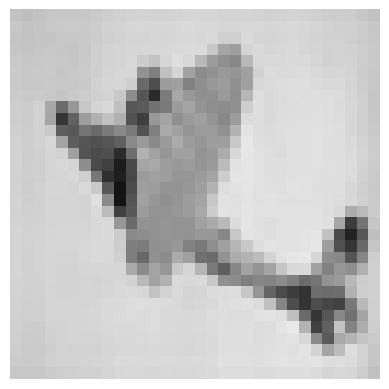

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

cnn: Prediction: airplane, Actual: airplane
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

resnet: Prediction: airplane, Actual: airplane
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

vgg16: Prediction: airplane, Actual: airplane
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

efficientnet: Prediction: ship, Actual: airplane


In [ ]:
index = random.randint(0, len(x_test) - 1)

plt.imshow(x_test[index])
plt.axis('off')
plt.show()

def print_checking_answer(model, x, y):
  predicted_label = np.argmax(model.predict(x))
  actual_label = np.argmax(y)
  print(f'\n{model.name}: Prediction: {class_names[predicted_label]}, Actual: {class_names[actual_label]}')

for model in [cnn_model, resnet_model, vgg16_model, effnet_model]:
  print_checking_answer(model, x_test[index], y_test[index])
